# X-ray analysis

In [9]:
import large_image_viewer
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import pandas as pd

from ipywidgets import interact
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

In this notebook, I will carry out a simple analysis of the X-ray images. The information contained in these scans can serve as a good groundtruth, as these scans allow to see the inside of the pole, thus allowing for giving an estimate of the pole's density, and thus, its strength.

So far, I only have the scan of pole 5, as each scan is 38GB in size! Thus, reading this whole scan into RAM at once is virtually impossible. Thankfully, by navigating the not-so-well-documented Napari plugin documentation, I've figured out how to access this data outside of the Napari visualizer without running into RAM issues.

## Preliminary X-ray analysis

In [10]:
def show_pole(path, along):
    dask_reader = large_image_viewer.napari_get_reader(path)(path)[0][0]
    
    def browse_images(reader):
        bands = reader.shape[along]
        def view_images(i=0):
            img = reader[i, :, :].compute() if along==0 else (reader[:,i,:].compute() if along==1 else reader[:,:,i].compute())
            #img = np.where(img < 14000, 0, 1)
            plt.imshow(img, cmap='gray', interpolation='nearest', vmin=0, vmax=65535)
            plt.title(f'X-ray frame #{i}')
            plt.show()
        interact(view_images, i=(0, bands - 1))
    browse_images(dask_reader)

In [3]:
show_pole('../../Ghent Xray/Tree log 34021 - 5.tif', along=0)

../../Ghent Xray/Tree log 34021 - 5.tif


KeyboardInterrupt: 

## Scan reduction

An exploration of this pole (recall that it is pole 5) shows patterns already seen on the RGB scans of this pole: while the top part of the pole is "relatively" intact, the bottom part is heavily damaged by rot. It is straightforward that, the more damaged by cracks/rot a pole is, the smaller its density will be; and less density will imply less strength. Therefore, these scans are a good source for building a good groundtruth for this problem.

A way of doing this is measuring how the average density of the pole changes along its vertical length, in circular slices of the pole. However, given the huge size of the scan, it is better to reduce it first.

In [3]:
def reduce_dimensionality(path_or_array, factor=10):
    if (type(path_or_array) is str):
        reader = large_image_viewer.napari_get_reader(path_or_array)(path_or_array)[0][0]
    
    elif (type(path_or_array) is np.ndarray):
        reader = path_or_array
    
    # Collapse along Y-axis
    y_collapse_buffer = []
    i = 0
    while i < reader.shape[0]:
        print(f'Processing Y-dimension {i}', end='\r')
        result = np.mean(reader[i:i+factor,:,:].compute() if type(path_or_array) is str else reader[i:i+factor,:,:], axis=0)
        result = result.astype(np.uint16)
        y_collapse_buffer.append(result)
        i += factor
    
    y_collapse_buffer = np.stack(y_collapse_buffer, axis=0)
    print()
    
    # Collapse along first horizontal axis
    x_collapse_buffer = []
    i = 0
    while i < y_collapse_buffer.shape[1]:
        print(f'Processing X-dimension {i}', end='\r')
        result = np.mean(y_collapse_buffer[:,i:i+factor,:], axis=1)
        result = result.astype(np.uint16)
        x_collapse_buffer.append(result)
        i += factor
        
    x_collapse_buffer = np.stack(x_collapse_buffer, axis=1)
    print()
    
        
    # Collapse along second horizontal axis
    z_collapse_buffer = []
    i = 0
    while i < x_collapse_buffer.shape[2]:
        print(f'Processing Z-dimension {i}', end='\r')
        result = np.mean(x_collapse_buffer[:,:,i:i+factor], axis=2)
        result = result.astype(np.uint16)
        z_collapse_buffer.append(result)
        i += factor
        
    z_collapse_buffer = np.stack(z_collapse_buffer, axis=2)
        
    return z_collapse_buffer

In [188]:
reduced_scan_5 = reduce_dimensionality('../Data/X-ray/Tree log 34021 - 5.tif')
with open('../Data/X-ray/pole5_reduced.npy', 'wb') as f:
    np.save(f, reduced_scan_5)

../Data/X-ray/Tree log 34021 - 5.tif
method tiff, image shape: (6560, 1776, 1749)
Loading file using large-image-viewer plugin
Processing Y-dimension 6550
Processing X-dimension 1770


In [3]:
with open('../../Ghent Xray/pole5_reduced_10.npy', 'rb') as f:
    reduced_scan_5 = np.load(f)

In [35]:
more_reduced = reduce_dimensionality(reduced_scan, factor=5)

Processing Y-dimension 655
Processing X-dimension 175


In [27]:
def browse_images(arr, along, savefile):
    bands = arr.shape[along]
    def view_images(i=0):
        img = arr[i, :, :] if along==0 else (arr[:,i,:] if along==1 else arr[:,:,i])
        plt.imshow(img, cmap='gray', interpolation='nearest', vmin=0, vmax=65535)
        #plt.title(f'X-ray frame #{i}')
        plt.xticks([])
        plt.yticks([])
        plt.savefig(savefile, bbox_inches='tight')
        plt.show()
    interact(view_images, i=(0, bands - 1))

In [11]:
browse_images(reduced_scan_5, along=0)

interactive(children=(IntSlider(value=0, description='i', max=655), Output()), _dom_classes=('widget-interact'…

## Proper scan analysis

Now that the dimensionality has been properly reduced, it is feasible to create a plot of how the pole density changes along all the axes, by showing the cross-section area along all axes. This can help characterise the most critical aspects of each pole that might help predicting its remaining lifetime: diameter along its vertical, presence of rot, etc. All these characteristics can be reflected by these plots.

In [130]:
def get_density_along_axes(arr, norm=False):
    densities_y = []
    densities_x = []
    densities_z = []
    
    # Vertical axis
    for idx in range(arr.shape[0]):
        img = arr[idx, :, :]
        densities_y.append(np.mean(img))
        
    # First horizontal axis
    for idx in range(arr.shape[1]):
        img = arr[:, idx, :]
        densities_x.append(np.mean(img))
        
    # Second horizontal axis
    for idx in range(arr.shape[2]):
        img = arr[:, :, idx]
        densities_z.append(np.mean(img))
        
    # Normalize sizes of the arrays
    if norm:
        densities_y = cv2.resize(np.array([densities_y], dtype=np.float32), dsize=(200,1))[0]
        densities_x = cv2.resize(np.array([densities_x], dtype=np.float32), dsize=(200,1))[0]
        densities_z = cv2.resize(np.array([densities_z], dtype=np.float32), dsize=(200,1))[0]
    
    # Trim first and last slices to remove background effects
    return (densities_y[1:-1], densities_x[1:-1], densities_z[1:-1])

In [218]:
densities_y, densities_x, densities_z = get_density_along_axes(reduced_scan)

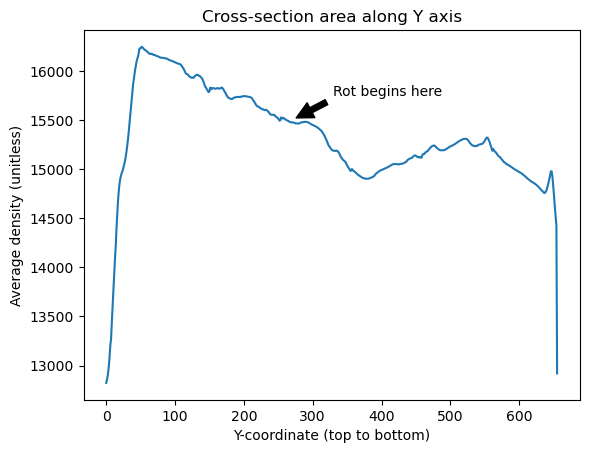

In [219]:
plt.plot(range(len(densities_y)), densities_y)
plt.title('Cross-section area along Y axis')
plt.xlabel('Y-coordinate (top to bottom)')
plt.ylabel('Average density (unitless)')
plt.annotate('Rot begins here', xy=(270,15500), xytext=(330,15750), arrowprops=dict(facecolor='black', shrink=0.1))
plt.savefig('../Figures/Xray_Y.png')

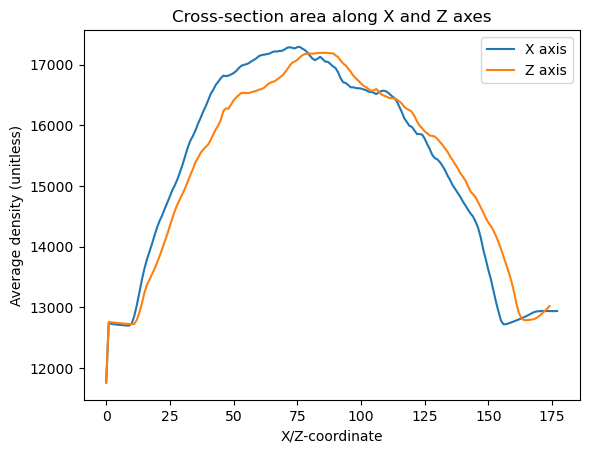

In [220]:
plt.plot(range(len(densities_x)), densities_x, label='X axis')
plt.plot(range(len(densities_z)), densities_z, label='Z axis')
plt.title('Cross-section area along X and Z axes')
plt.xlabel('X/Z-coordinate')
plt.ylabel('Average density (unitless)')
plt.legend()
plt.savefig('../Figures/Xray_XZ.png')

From these plots, some key insights can be deduced:
- First, the Y axis plot confirms what can be seen from a visual inspection of pole: the density on the top part of the pole is relatively good, but on the bottom part the density has a sudden drop. This is due to the presence of rot in this part of the pole, even though it would be difficult to ascertain with the X-ray scan alone that this density drop is due to rot.
- Second, the X and Z axes scans show that the pole seems to be very symmetric on both axes, as both plots closely follow each other. These plots also show that the pole doesn't seem to be hollow on the inside, as in this case, the expected result would have been a sudden drop around the center of the plot.

Therefore, it can be seen that these scans can serve as a good groundtruth source for estimating the status of a pole. However, this data is still a groundtruth too big for proper prediction. From all the knowledge I have gathered so far, there are some factors to have into account:
- The bottom of the pole is much more influential than the top to determine its status, as it has to support much more weight.
- Hollow poles should have sudden density drops in the X and Z axes. I can't confirm this with pole 5, so I'll ask for the pole 30 scan later.

## Going polar: analysing the pole in polar coordinates

Before settling on a definitive groundtruth, however, it is a good idea to also look at the unrolled version of the pole, in polar coordinates. Polar, because it is for the pole 🙂

In [57]:
# Convert the scan from cartesian coordinates to polar coordinates
def scan_to_polar(scan_data, radius, angle_samples, integration_interval):
    result = np.zeros(shape=(scan_data.shape[0], angle_samples))
    center_x, center_z = scan_data.shape[1] // 2, scan_data.shape[2] // 2
    integration_samples = math.ceil(radius * integration_interval[1] - radius * integration_interval[0])
    
    # For each height slice and angle sample, integrate "integration_samples" value in the "integration_interval" part of the radius
    for vertical_slice in range(scan_data.shape[0]):
        for angle_sample in range(angle_samples):
            # Get X and Y coordinates of the limits of the sample circle
            angle = (angle_sample / angle_samples) * 2 * math.pi
            x_limit_sample = radius * math.cos(angle)
            z_limit_sample = radius * -math.sin(angle)
            
            accumulator = 0
            for radius_factor in np.linspace(integration_interval[0], integration_interval[1], integration_samples):
                x_sample = int(center_x + x_limit_sample * radius_factor)
                z_sample = int(center_z + z_limit_sample * radius_factor)
                accumulator += scan_data[vertical_slice, x_sample, z_sample]
            
            result[vertical_slice, angle_sample] = accumulator / integration_samples
    
    return result

In [201]:
result_surface = scan_to_polar(reduced_scan, 75, 1000, (0.90, 1))

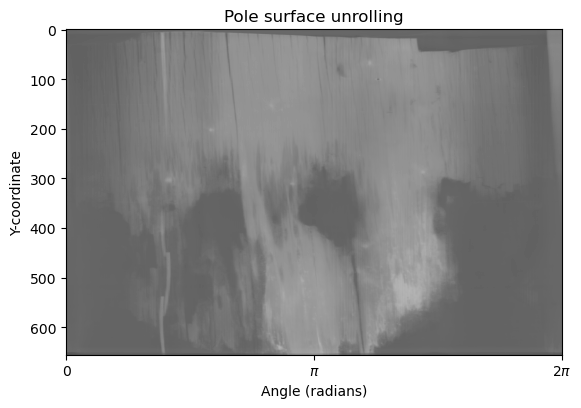

In [222]:
plt.xlabel("Angle (radians)")
plt.xticks([0,500,999], ["0", "$\pi$", "$2\pi$"])
plt.ylabel("Y-coordinate")
plt.imshow(result_surface, cmap='gray', vmin=0, vmax=32000)
plt.title("Pole surface unrolling");
plt.savefig('../Figures/Xray_unroll_surface.png')

In [203]:
result_interior = scan_to_polar(reduced_scan, 75, 1000, (0, 0.5))

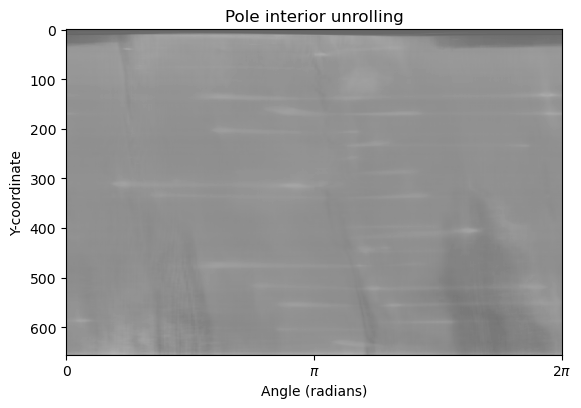

In [223]:
plt.xlabel("Angle (radians)")
plt.xticks([0,500,999], ["0", "$\pi$", "$2\pi$"])
plt.ylabel("Y-coordinate")
plt.imshow(result_interior, cmap='gray', vmin=0, vmax=32000)
plt.title("Pole interior unrolling");
plt.savefig('../Figures/Xray_unroll_interior.png')

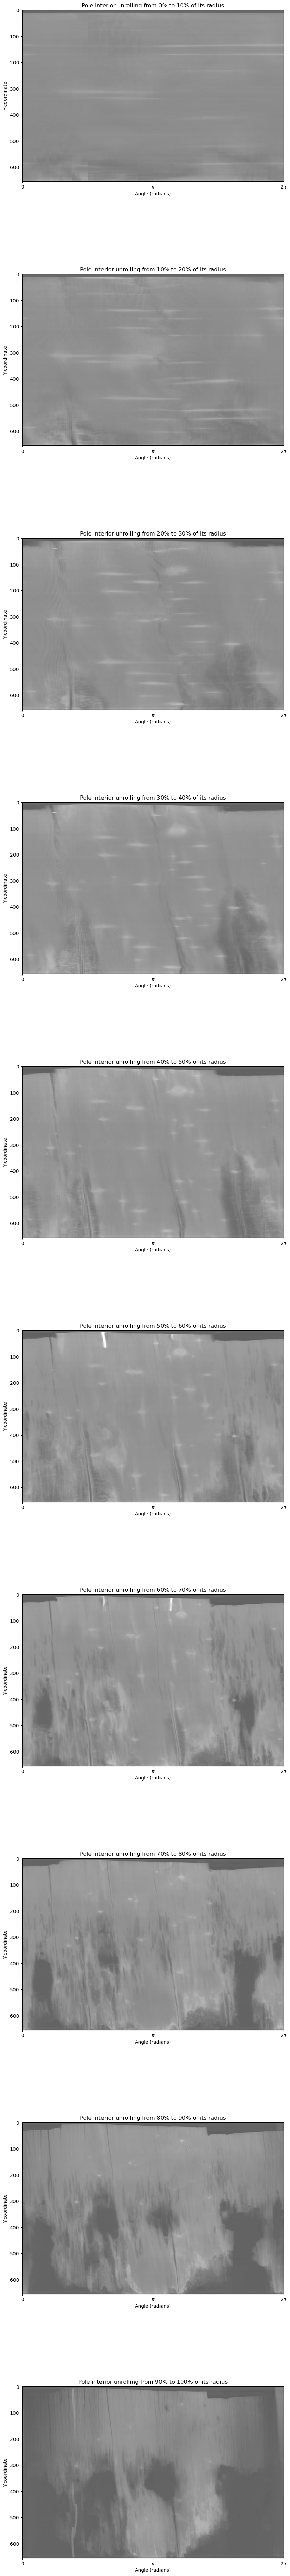

In [ ]:
fig, axes = plt.subplots(nrows=10, figsize=(10,100))

for i in range(10):
    result = scan_to_polar(reduced_scan, 75, 1000, (i*0.1, (i+1)*0.1))
    axes[i].set_xlabel("Angle (radians)")
    axes[i].set_xticks([0,500,999], ["0", "$\pi$", "$2\pi$"])
    axes[i].set_ylabel("Y-coordinate")
    axes[i].title.set_text(f"Pole interior unrolling from {i*10}% to {(i+1)*10}% of its radius")
    axes[i].imshow(result, cmap='gray', vmin=0, vmax=32000)

## Pole 30: internal rot characterisation

With the X-ray scan of pole 30 now available, it should now be possible to figure out whether these scans can serve for characterising internal rot!

In [5]:
show_pole('../../Ghent Xray/Tree log 34023 - 30.tif', along=0)

../../Ghent Xray/Tree log 34023 - 30.tif
method tiff, image shape: (7063, 1777, 1752)
Loading file using large-image-viewer plugin


interactive(children=(IntSlider(value=0, description='i', max=7062), Output()), _dom_classes=('widget-interact…

In [8]:
reduced_scan_30 = reduce_dimensionality('../../Ghent Xray/Tree log 34023 - 30.tif')
with open('../../Ghent Xray/pole30_reduced_10.npy', 'wb') as f:
    np.save(f, reduced_scan_30)

../../Ghent Xray/Tree log 34023 - 30.tif
method tiff, image shape: (7063, 1777, 1752)
Loading file using large-image-viewer plugin
Processing Y-dimension 7060
Processing X-dimension 1770


In [7]:
with open('../../Ghent Xray/pole30_reduced_10.npy', 'rb') as f:
    reduced_scan_30 = np.load(f)

In [63]:
browse_images(reduced_scan_30, along=0)

interactive(children=(IntSlider(value=0, description='i', max=706), Output()), _dom_classes=('widget-interact'…

As it can be seen in this downsampled version of the scans, pole 30 presents characteristics that differ from pole 5, and these are due to internal rot. While the surface of the pole seems relatively OK, the interior is severely damaged by rot. This kind of damage is dangerous, as it not only affects the pole's strength, but it is also much harder to detect than external rot or external cracks.

Still, it is good to obtain the same plots as before, to see if the previously proposed groundtruth idea might serve for this. Now that there is data for two different poles, it is possible to compare them and check their respective density curves.

In [42]:
densities_y_5, densities_x_5, densities_z_5 = get_density_along_axes(reduced_scan_5)
densities_y_30, densities_x_30, densities_z_30 = get_density_along_axes(reduced_scan_30)

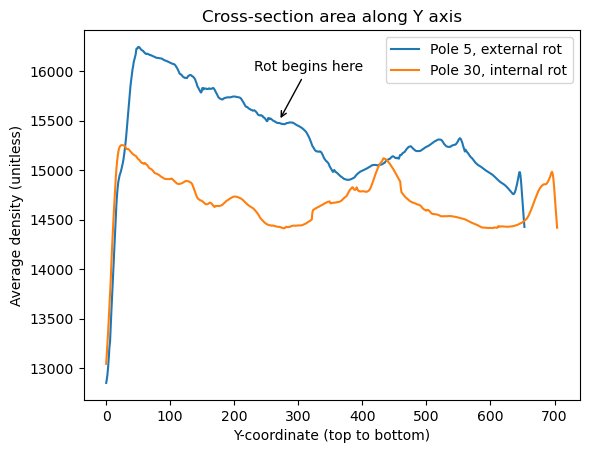

In [54]:
plt.plot(range(len(densities_y_5)), densities_y_5, label='Pole 5, external rot')
plt.plot(range(len(densities_y_30)), densities_y_30, label='Pole 30, internal rot')
plt.title('Cross-section area along Y axis')
plt.xlabel('Y-coordinate (top to bottom)')
plt.ylabel('Average density (unitless)')
plt.annotate('Rot begins here', xy=(270,15500), xytext=(230,16000), arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.legend()
plt.savefig('../Figures/Xray_Y.png')

This plots show very important insights about the poles. By comparing the density curves of both poles side to side, it is possible to see how these are different. While pole 5 begins with a high density that decays gradually due to external rot in the bottom part, pole 30 already begins at low density and shows little variance, due to internal rot all along the pole.

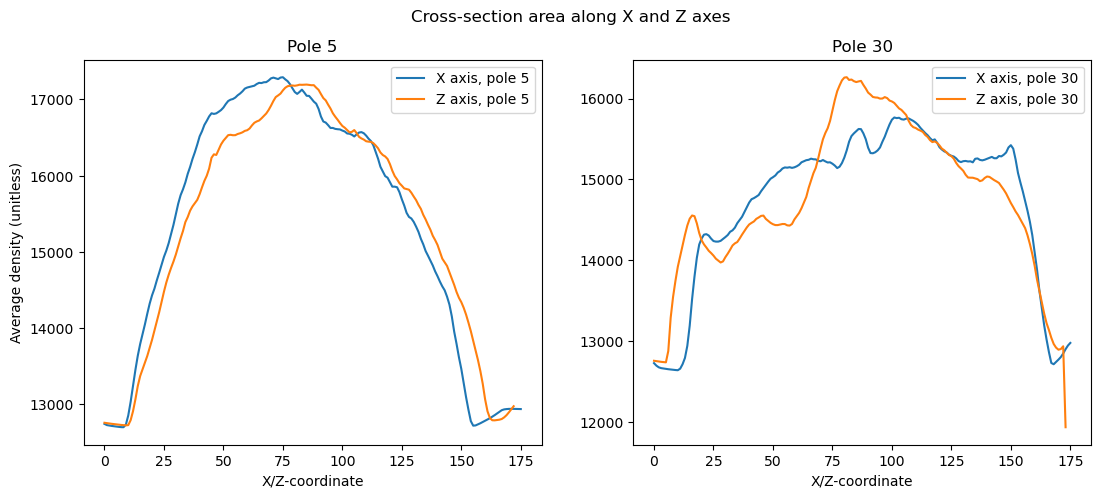

In [56]:
fig, axes = plt.subplots(ncols=2, figsize=(13,5))
axes[0].plot(range(len(densities_x_5)), densities_x_5, label='X axis, pole 5')
axes[0].plot(range(len(densities_z_5)), densities_z_5, label='Z axis, pole 5')
axes[1].plot(range(len(densities_x_30)), densities_x_30, label='X axis, pole 30')
axes[1].plot(range(len(densities_z_30)), densities_z_30, label='Z axis, pole 30')
fig.suptitle('Cross-section area along X and Z axes')
axes[0].set_xlabel('X/Z-coordinate')
axes[1].set_xlabel('X/Z-coordinate')
axes[0].set_ylabel('Average density (unitless)')
axes[0].legend()
axes[1].legend()
axes[0].title.set_text('Pole 5')
axes[1].title.set_text('Pole 30')
plt.savefig('../Figures/Xray_XZ.png')

By comparing the plots of the density curves along the horizontal axes, further distinctive charactersitics can be seen in these poles:
- The density curves for pole 5 are almost sine-wave like, and both curves follow each other very closely. Since there are no drops in the middle on the curve, this indicates the interior is relatively intact, and the pole has a good level of density symmetry on both axes.
- The density curves for pole 30 are only very loosely sine-wave shaped, as they have lots of drops in the middle part. In addition, these curves have very different shapes, indicating that the pole density is assymetrical on both horizontal axes. These characteristics indicate that the pole seems to have holes inside, and these are not symmetrical.

As it was done with pole 5, it is also interesting to analyze the insides of pole 30, to see if surface characteristics and internal rot can be characterized separately.

In [58]:
result_surface = scan_to_polar(reduced_scan_30, 75, 1000, (0.90, 1))
result_interior = scan_to_polar(reduced_scan_30, 75, 1000, (0, 0.5))

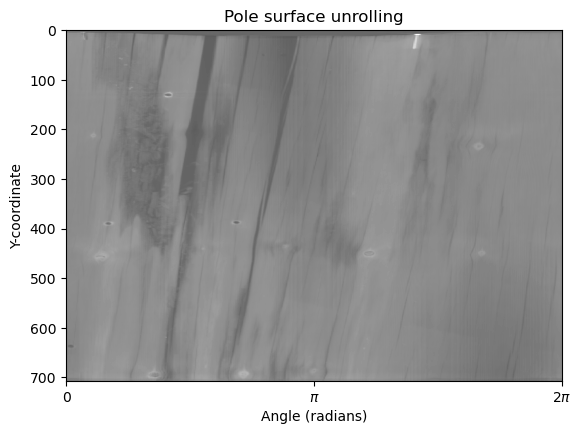

In [60]:
plt.xlabel("Angle (radians)")
plt.xticks([0,500,999], ["0", "$\pi$", "$2\pi$"])
plt.ylabel("Y-coordinate")
plt.imshow(result_surface, cmap='gray', vmin=0, vmax=32000)
plt.title("Pole surface unrolling");
plt.savefig('../Figures/Xray_unroll_surface_30.png')

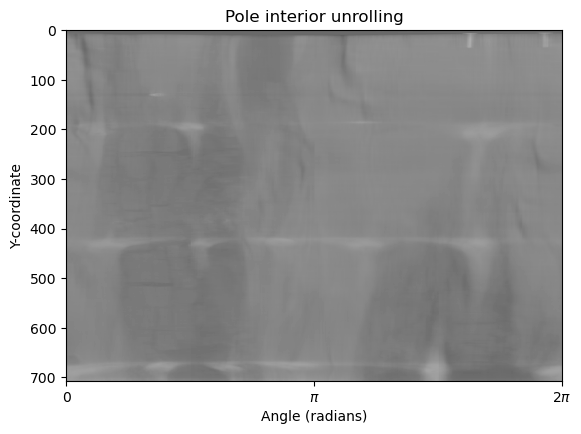

In [61]:
plt.xlabel("Angle (radians)")
plt.xticks([0,500,999], ["0", "$\pi$", "$2\pi$"])
plt.ylabel("Y-coordinate")
plt.imshow(result_interior, cmap='gray', vmin=0, vmax=32000)
plt.title("Pole interior unrolling");
plt.savefig('../Figures/Xray_unroll_interior_30.png')

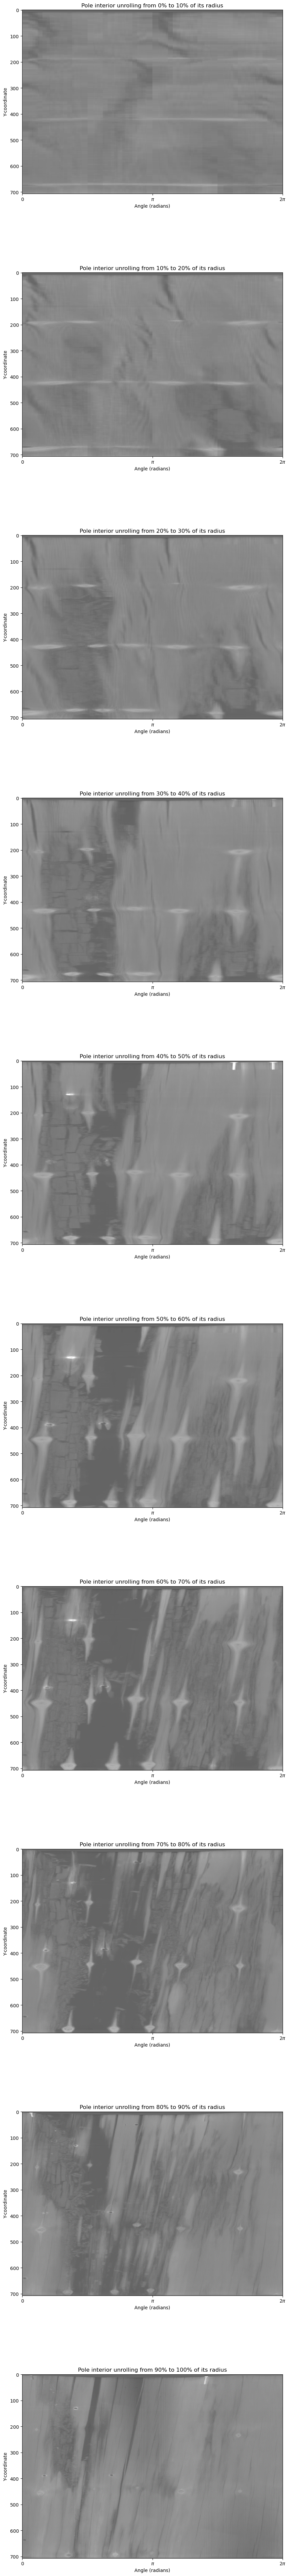

In [62]:
fig, axes = plt.subplots(nrows=10, figsize=(10,100))

for i in range(10):
    result = scan_to_polar(reduced_scan_30, 75, 1000, (i*0.1, (i+1)*0.1))
    axes[i].set_xlabel("Angle (radians)")
    axes[i].set_xticks([0,500,999], ["0", "$\pi$", "$2\pi$"])
    axes[i].set_ylabel("Y-coordinate")
    axes[i].title.set_text(f"Pole interior unrolling from {i*10}% to {(i+1)*10}% of its radius")
    axes[i].imshow(result, cmap='gray', vmin=0, vmax=32000)

As it can be seen in these scans, this first proposal of polar unrolling for creating a proper groundtruth still needs some refinement. As it can be seen, the current interior scan is not able to capture the real amount of hollowness inside the pole. Therefore, a better idea could be dividing the radius in thirds, thus obtaining unrollings for the surface third, the middle third, and the core third.

## Groundtruth proposal: thirds

In [69]:
def polar_thirds(scan, pole_id):
    fig, axes = plt.subplots(ncols=3, figsize=(21,7))
    result_surface = scan_to_polar(scan, 75, 1000, (0.66, 1))
    result_middle = scan_to_polar(scan, 75, 1000, (0.33, 0.66))
    result_interior = scan_to_polar(scan, 75, 1000, (0, 0.33))
    
    axes[0].set_xlabel("Angle (radians)")
    axes[1].set_xlabel("Angle (radians)")
    axes[2].set_xlabel("Angle (radians)")
    axes[0].set_xticks([0,500,999], ["0", "$\pi$", "$2\pi$"])
    axes[1].set_xticks([0,500,999], ["0", "$\pi$", "$2\pi$"])
    axes[2].set_xticks([0,500,999], ["0", "$\pi$", "$2\pi$"])
    axes[0].set_ylabel("Y-coordinate")
    axes[0].imshow(result_surface, cmap='gray', vmin=0, vmax=32000)
    axes[1].imshow(result_middle, cmap='gray', vmin=0, vmax=32000)
    axes[2].imshow(result_interior, cmap='gray', vmin=0, vmax=32000)
    axes[0].title.set_text("Pole surface unrolling")
    axes[1].title.set_text("Pole middle unrolling")
    axes[2].title.set_text("Pole interior unrolling")
    
    fig.suptitle(f'Pole {pole_id}')

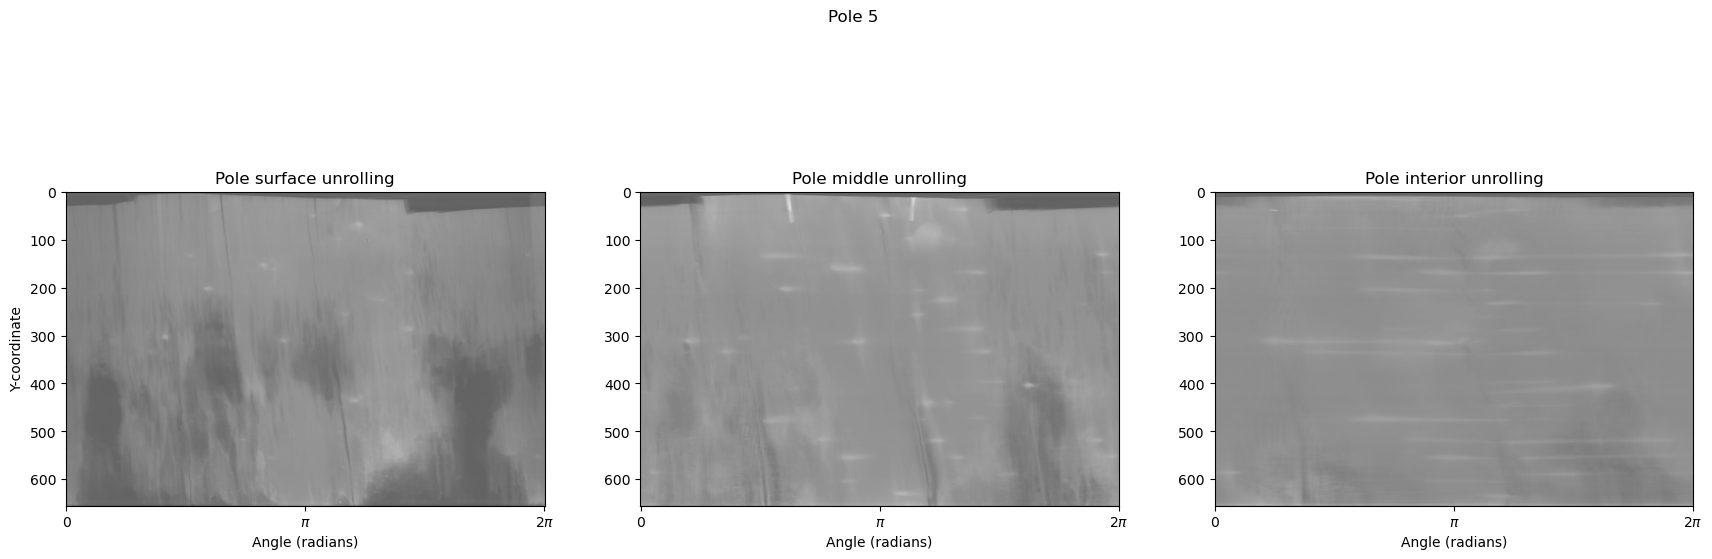

In [70]:
polar_thirds(reduced_scan_5, 5)

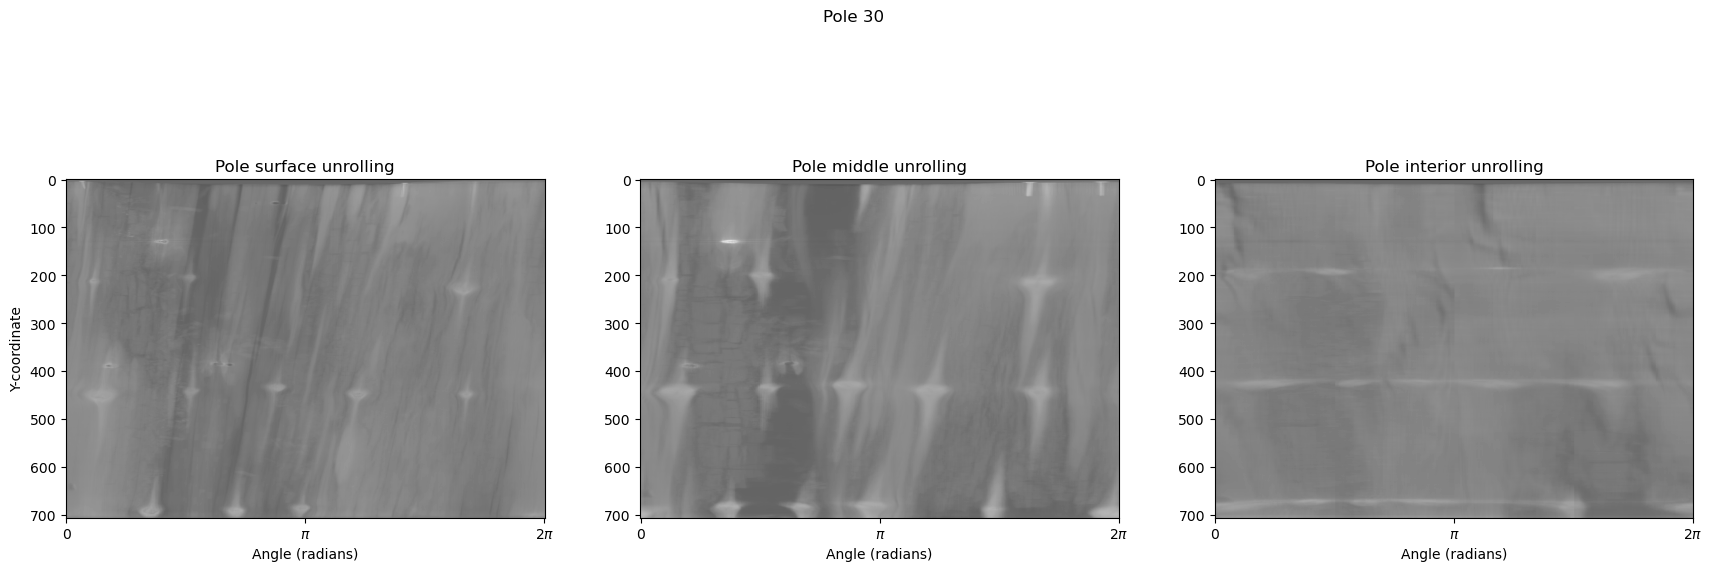

In [71]:
polar_thirds(reduced_scan_30, 30)

As it can be seen, differences can now be seen between the two poles:
- Regarding the pole interior, both seem to be in a similar state.
- Regarding the surface, it can be seen that pole 5 is in worse state than the surface of pole 30.
- Regarding the middle, it can clearly be seen that pole 30 has much less density that pole 5, due to its internal rot.

## All together: X-ray scans of the 5 poles.

Now that the X-ray scans of the 5 poles are all available, it is a good idea to compare all these at once, to see how poles differ among themselves

### New poles downsampling

In [8]:
reduced_scan_6 = reduce_dimensionality('../../Ghent Xray/Tree log 34021 - 6.tif')
with open('../../Ghent Xray/pole6_reduced_10.npy', 'wb') as f:
    np.save(f, reduced_scan_6)
    
reduced_scan_ny = reduce_dimensionality('../../Ghent Xray/NY Stolpe - AEN 20201013.tif')
with open('../../Ghent Xray/poleny_reduced_10.npy', 'wb') as f:
    np.save(f, reduced_scan_ny)
    
reduced_scan_41 = reduce_dimensionality('../../Ghent Xray/Tree log 01337 - 41.tif')
with open('../../Ghent Xray/pole41_reduced_10.npy', 'wb') as f:
    np.save(f, reduced_scan_41)

../../Ghent Xray/Tree log 34021 - 6.tif
method tiff, image shape: (6767, 1776, 1749)
Loading file using large-image-viewer plugin



KeyboardInterrupt



In [11]:
with open('../../Ghent Xray/pole5_reduced_10.npy', 'rb') as f:
    reduced_scan_5 = np.load(f)
    
with open('../../Ghent Xray/pole30_reduced_10.npy', 'rb') as f:
    reduced_scan_30 = np.load(f)
    
with open('../../Ghent Xray/pole6_reduced_10.npy', 'rb') as f:
    reduced_scan_6 = np.load(f)
    
with open('../../Ghent Xray/pole41_reduced_10.npy', 'rb') as f:
    reduced_scan_41 = np.load(f)
    
with open('../../Ghent Xray/poleny_reduced_10.npy', 'rb') as f:
    reduced_scan_ny = np.load(f)

In [32]:
browse_images(reduced_scan_ny, 1, "xray-ny.png")

interactive(children=(IntSlider(value=0, description='i', max=177), Output()), _dom_classes=('widget-interact'…

### Density curves of all poles

With these downsampled scans, it is now possible to plot all density curves at once

In [141]:
def plot_density_curves_vertical(scans, ids):
    fig, axes = plt.subplots(figsize=(7, 7))
    
    for idx, (scan, pole_id) in enumerate(zip(scans, ids)):
        densities_y, densities_x, densities_z = get_density_along_axes(scan, norm=True)
        axes.plot(range(len(densities_y)), densities_y, label=f'Pole {pole_id}')
        axes.set_xlabel('Y-coordinate (top to bottom)')

    axes.set_ylabel('Average density (unitless)')
    fig.suptitle('Cross-section density along Y axis')
    axes.legend()
    fig.savefig('../Figures/Xray_vertical_densities.png')
    
def plot_density_curves_horizontal(scans, ids):
    fig, axes = plt.subplots(ncols=len(scans), figsize=(7*len(scans), 7))
    
    for idx, (scan, pole_id) in enumerate(zip(scans, ids)):
        densities_y, densities_x, densities_z = get_density_along_axes(scan, norm=False)
        axes[idx].plot(range(len(densities_x)), densities_x, label='X axis')
        axes[idx].plot(range(len(densities_z)), densities_z, label='Z axis')
        axes[idx].set_xlabel('Y-coordinate (top to bottom)')
        axes[idx].title.set_text(f'Pole {pole_id}')
        axes[idx].set_ylim([10000,22000])
        axes[idx].legend()

    axes[0].set_ylabel('Average density (unitless)')
    fig.suptitle('Cross-section density along horizontal axes')
    fig.savefig('../Figures/Xray_horizontal_densities.png')

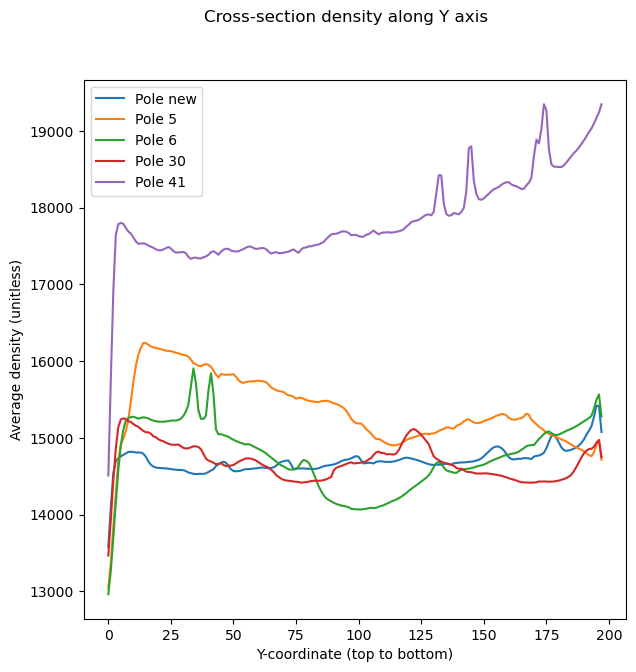

In [137]:
plot_density_curves_vertical([reduced_scan_ny, reduced_scan_5, reduced_scan_6, reduced_scan_30, reduced_scan_41], ["new", "5", "6", "30", "41"])

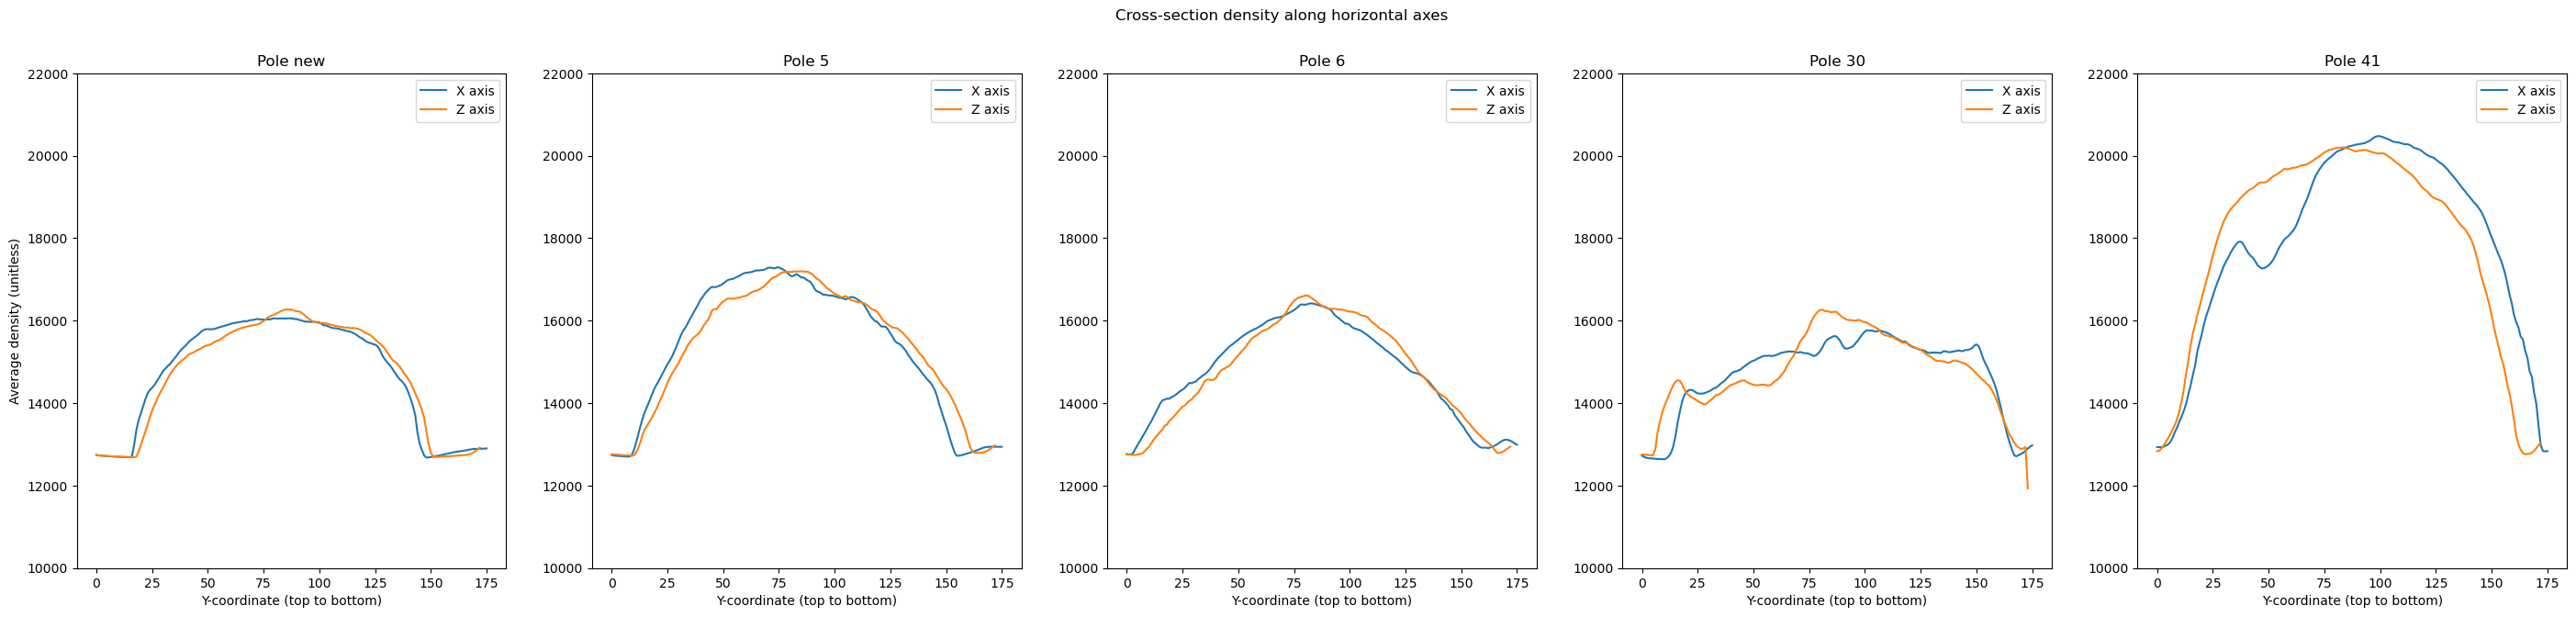

In [142]:
plot_density_curves_horizontal([reduced_scan_ny, reduced_scan_5, reduced_scan_6, reduced_scan_30, reduced_scan_41], ["new", "5", "6", "30", "41"])

By looking at these plots, further insights about the pole's statuses can be obtained:
- Pole 41 is far denser than the other poles. This has been confirmed empirically, as this pole was much harder to lift than the others when LiDAR scans were obtained.
- Even if pole 41 was previously labeled as "containing cracks", there is also a non-neglibigle amount of internal rot on it, as its horizontal axes plot shows. In turn, this internal rot also leads to a certain level of assymetry in its density curve.
- As expected, the new pole has the most symmetrical horizontal density curves. Even if its density is not the largest one, it has a very stable density curve along the vertical axis. These two characteristics indicate that it is a smooth pole.
- The horizontal density curves for pole 6 are very symmetrical. However, it has a sudden drop in its vertical density curve. This indicates that it has surface damage, which can be verified with a visual scan of both the pole and the X-ray images.
- For some poles, there are sudden density spikes. These are actually due to the metal present in them, that appears as a very bright element in the X-ray scans.

### Polar unrollings of all poles

In [158]:
def polar_thirds_multiple(scans, ids):
    fig, axes = plt.subplots(nrows=len(scans), ncols=3, figsize=(21,6*len(scans)))
    polar_unrolls = {}
    
    for idx, (scan, pole_id) in enumerate(zip(scans, ids)):
        result_surface = scan_to_polar(scan, 75, 1000, (0.66, 1))
        result_middle = scan_to_polar(scan, 75, 1000, (0.33, 0.66))
        result_interior = scan_to_polar(scan, 75, 1000, (0, 0.33))

        axes[idx,0].set_xlabel("Angle (radians)")
        axes[idx,1].set_xlabel("Angle (radians)")
        axes[idx,2].set_xlabel("Angle (radians)")
        axes[idx,0].set_xticks([0,500,999], ["0", "$\pi$", "$2\pi$"])
        axes[idx,1].set_xticks([0,500,999], ["0", "$\pi$", "$2\pi$"])
        axes[idx,2].set_xticks([0,500,999], ["0", "$\pi$", "$2\pi$"])
        axes[idx,0].set_ylabel("Y-coordinate")
        axes[idx,0].imshow(result_surface, cmap='gray', vmin=0, vmax=32000)
        axes[idx,1].imshow(result_middle, cmap='gray', vmin=0, vmax=32000)
        axes[idx,2].imshow(result_interior, cmap='gray', vmin=0, vmax=32000)
        axes[idx,0].title.set_text(f"Pole {pole_id} surface unrolling")
        axes[idx,1].title.set_text(f"Pole {pole_id} middle unrolling")
        axes[idx,2].title.set_text(f"Pole {pole_id} interior unrolling")
        
        polar_unrolls[pole_id] = [result_surface, result_middle, result_interior]
    
    plt.tight_layout()   
    plt.savefig('../Figures/Xray_unroll_all.png')
    return polar_unrolls

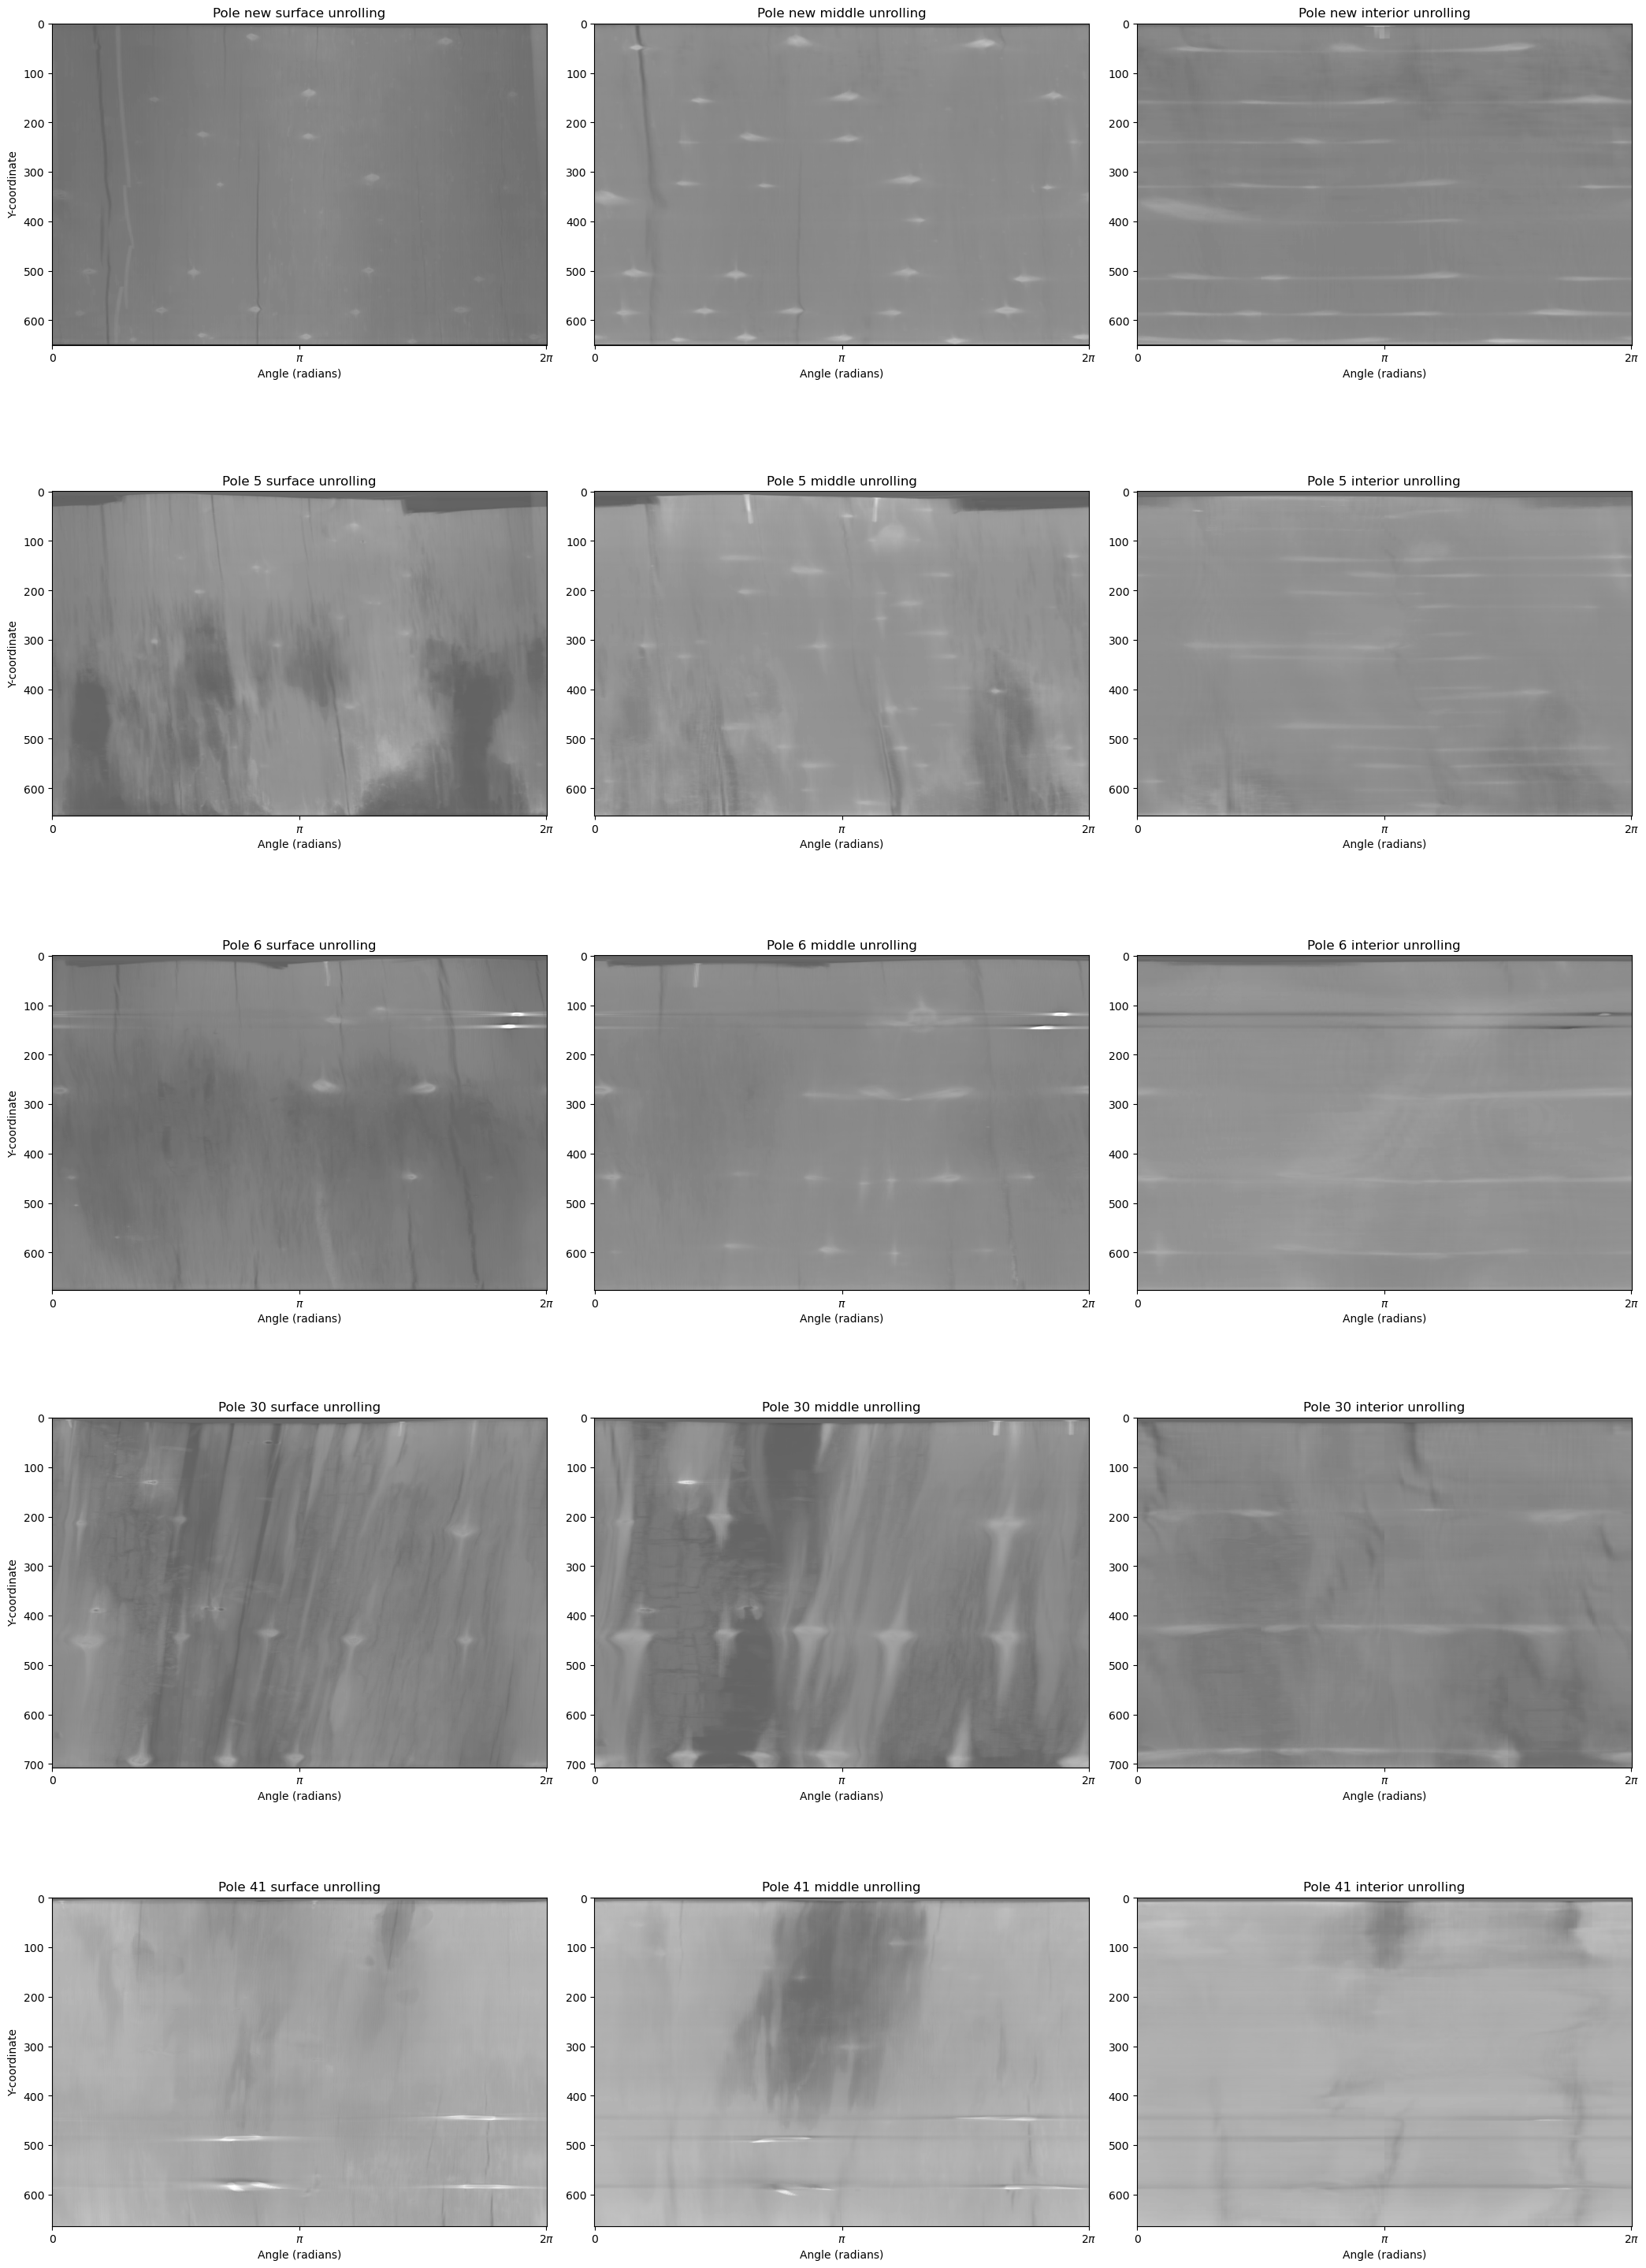

In [159]:
polar_gts = polar_thirds_multiple([reduced_scan_ny, reduced_scan_5, reduced_scan_6, reduced_scan_30, reduced_scan_41], ["new", "5", "6", "30", "41"])

Thanks to these polar unrolling plots, it is now possible to see more differences between all the poles that, hopefully, will allow to establish a better groundtruth. These are:
- In the new pole, there are no remarkable characteristics in any of the unrolls. The pole looks OK on both its surface, middle and interior areas.
- In pole 5, the external damage due to rot is clearly visible on the surface unrolling plot. There is not a great amount of damage on the middle and interior areas, though.
- In pole 6, something similar to pole 5 can be seen, as there is also external damage, but not as extreme as that of pole 5. Furthermore, pole 6 is also less dense than 5.
- For pole 30, heavy damage can be seen, both on its external and middle layers, due to cracks and rot.
- For pole 41, just some internal rot can be seen, as its cracks don't seem to be extremely worrying.

Thus, there are clear distinctions between each of the 5 poles. Based on all the data I have analysed so far, I have two hypotheses:
- Based on density and damages, the proper ordering of the poles could be, from better to worse: New > 41 > 6 > 5 > 30
- Even if a single pole could be considered an observational unit by itself, it is clear that the topmost part of the pole will have a different nature than the bottom, as the latter has to support the whole weight of the pole. Therefore, my idea is to treat the pole differently depending on its height, thus dividing the pole into many observational units: slices of the pole along its vertical axis. In the observed data (pictures, scans), each slice could be used to predict the status of its corresponding X-ray groundtruth slice.

## Another groundtruth proposal: thirds + slices

Taking these thirds scans as starting point, it should be easy to create this new groundtruth. However, outliers (metal reflections) should be removed first, and replaced by, for example, the scan mean.

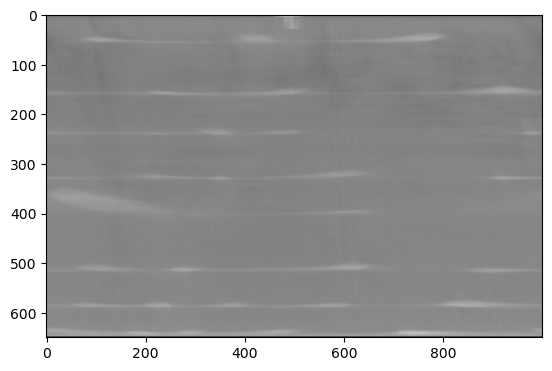

In [227]:
test_pole = polar_gts['new'][2]
test_pole_mean = np.mean(test_pole)
test_pole_clean = np.where(test_pole > 25000, test_pole_mean, test_pole)
plt.imshow(test_pole_clean, cmap='gray', vmin=0, vmax=32000)

By performing a visual analysis, it can be seen that a threshold of 25000 removes most of the metal X-ray artifacts. Therefore, the images will be cleaned this way.

With the images unrolled by thirds, it is now a good idea to plot how the density changes along the vertical axis for each pole and unroll.

In [247]:
def plot_density_thirds(unrolls, final_size=None):
    fig, axes = plt.subplots(ncols=len(unrolls), figsize=(5*len(unrolls),5))
    result_dict = {
        'pole_id': [],
        'height_id': [],
        'surface_density': [],
        'middle_density': [],
        'interior_density': []
    }
    
    for idx, unroll in enumerate(unrolls):
        # Remove outliers
        unroll_mean_sur = np.mean(unrolls[unroll][0])
        unroll_mean_mid = np.mean(unrolls[unroll][1])
        unroll_mean_int = np.mean(unrolls[unroll][2])
        unroll_clean_sur = np.where(unrolls[unroll][0] > 25000, unroll_mean_sur, unrolls[unroll][0])
        unroll_clean_mid = np.where(unrolls[unroll][1] > 25000, unroll_mean_mid, unrolls[unroll][1])
        unroll_clean_int = np.where(unrolls[unroll][2] > 25000, unroll_mean_int, unrolls[unroll][2])
        vertical_mean_sur = np.mean(unroll_clean_sur, axis=1)
        vertical_mean_mid = np.mean(unroll_clean_mid, axis=1)        
        vertical_mean_int = np.mean(unroll_clean_int, axis=1)
        
        # Downsample density plots if a downsample value is given
        if final_size:
            vertical_mean_sur = cv2.resize(np.array([vertical_mean_sur], dtype=np.float32), dsize=(final_size,1))[0]
            vertical_mean_mid = cv2.resize(np.array([vertical_mean_mid], dtype=np.float32), dsize=(final_size,1))[0]
            vertical_mean_int = cv2.resize(np.array([vertical_mean_int], dtype=np.float32), dsize=(final_size,1))[0]
        
        axes[idx].plot(range(len(vertical_mean_sur)), vertical_mean_sur, color='red', label='Surface')
        axes[idx].plot(range(len(vertical_mean_mid)), vertical_mean_mid, color='green', label='Middle')
        axes[idx].plot(range(len(vertical_mean_int)), vertical_mean_int, color='blue', label='Interior')
        axes[idx].title.set_text(f'Pole {unroll}')
        axes[idx].set_ylim([12500, 25000])
        axes[idx].set_xlabel('Y-coordinate (pixels)')
        axes[idx].legend()
        
        # Prepare DataFrame dict for groundtruth construction
        pole_id = 0 if unroll=='new' else int(unroll)
        result_dict['pole_id'] += ([pole_id] * final_size)
        result_dict['height_id'] += list(range(final_size))
        result_dict['surface_density'] += vertical_mean_sur.tolist()
        result_dict['middle_density'] += vertical_mean_mid.tolist()
        result_dict['interior_density'] += vertical_mean_int.tolist()
    
    axes[0].set_ylabel('Average density(unitless)')
    fig.suptitle('Average density along vertical axis, per pole and unroll sector')
    return result_dict

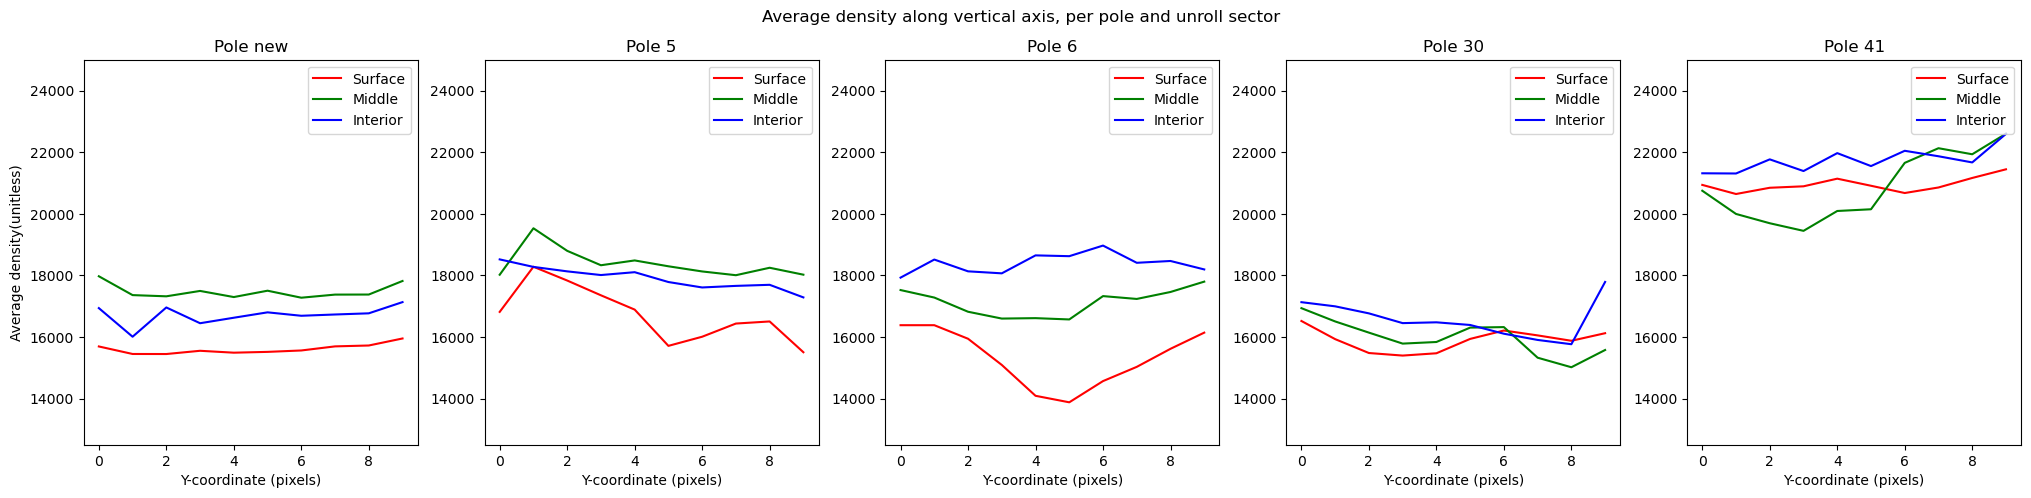

In [248]:
df_dict = plot_density_thirds(polar_gts, 10)

This data can now serve as a better groundtruth than the previous scores!

In [252]:
df = pd.DataFrame.from_dict(df_dict)
df.to_csv('poles.csv', index=False)

## [Another](https://media.tenor.com/a4yDwGZk4k4AAAAC/dj-khaled-another-one.gif) groundtruth for the surface

As suggested by Arnoud, I'm going to test another groundtruth value for the pole surface, also based on the polar unrolling. By going along the radius from the outside to the inside of the pole, a good way of characterising the surface would be keeping the depth of the first pixel that crosses a certain value threshold. This way, a good characterisation of the state of the surface can be obtained.

In [4]:
# Convert the scan from cartesian coordinates to polar coordinates
def scan_to_polar_surface(scan_data, angle_samples, intensity_threshold, crop_x, crop_z, final_size):
    cropped_scan = scan_data[:,crop_z,crop_x]
    result = np.zeros(shape=(cropped_scan.shape[0], angle_samples))
    center_x, center_z = cropped_scan.shape[1] // 2, cropped_scan.shape[2] // 2
    radius = 100
    samples = radius
    
    # For each height slice and angle sample, integrate "integration_samples" value in the "integration_interval" part of the radius
    for vertical_slice in range(cropped_scan.shape[0]):
        for angle_sample in range(angle_samples):
            # Get X and Y coordinates of the limits of the sample circle
            angle = (angle_sample / angle_samples) * 2 * math.pi
            x_limit_sample = radius * math.cos(angle)
            z_limit_sample = radius * -math.sin(angle)
            
            for radius_factor in np.linspace(1, 0, samples):
                x_sample = int(center_x + x_limit_sample * radius_factor)
                z_sample = int(center_z + z_limit_sample * radius_factor)
                if (not(0 <= z_sample < cropped_scan.shape[2]) or not(0 <= x_sample < cropped_scan.shape[1])):
                    continue
                if (cropped_scan[vertical_slice, x_sample, z_sample] > intensity_threshold):
                    result[vertical_slice, angle_sample] = radius_factor
                    break
    
    result = np.interp(result, (np.min(result),np.max(result)),(0,1))
    result_horizontal_avg = np.mean(result, axis=1)
    result_chunks = cv2.resize(np.array([result_horizontal_avg], dtype=np.float32), dsize=(final_size,1))[0]
    return result, result_chunks

In [5]:
# New, 5, 6, 30, 41. This is the order
def get_surface_gts(final_size):
    scans = [reduced_scan_ny, reduced_scan_5, reduced_scan_6, reduced_scan_30, reduced_scan_41]
    poles_crop_z = [slice(15,150), slice(10,155), slice(0,160), slice(10,170), slice(0,180)]
    poles_crop_x = [slice(15,160), slice(10,165), slice(5,170), slice(5,170) , slice(0,170)]
    pole_ids = [0,5,6,30,41]
    
    result_dict = {
        'pole_id': [],
        'height_id': [],
        'surface_depth': []
    }

    fig, axes = plt.subplots(nrows=5, figsize=(7,35))

    for idx, (pole_id, scan, crop_x, crop_z) in enumerate(zip(pole_ids, scans, poles_crop_x, poles_crop_z)):
        plot, chunks = scan_to_polar_surface(scan, 1000, 15000, crop_x, crop_z, final_size)
        axes[idx].imshow(plot, cmap='gray')
    
        result_dict['pole_id'] += ([pole_id] * final_size)
        result_dict['height_id'] += list(range(final_size))
        result_dict['surface_depth'] += chunks.tolist()
        
    return result_dict

In [ ]:
surface_data = get_surface_gts(10)
#df_surf = pd.DataFrame.from_dict(surface_data)
#df_surf.to_csv('poles_surface_depth.csv', index=False)